# panGI: Cell-cell communication inference at the single-cell level

### Load required libraries

In [1]:
import os
import pandas as pd
import numpy as np
import itertools

import decoupler as dc

import scanpy as sc
import liana as li

In [2]:
from scripts.plots import *
from scripts.utils import *

/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html


In [3]:
# needed for plotting
import matplotlib.pyplot as plt
import plotnine as p9

### load PROGENy pathways

In [4]:
lr_progeny = get_lr_progeny(path=os.path.join(os.path.join('data', 'lr_progeny.csv')))
lr_progeny.head()

,source,interaction,weight
60,JAK-STAT,LGALS9&PTPRC,1.307807
1568,Androgen,SEMA4D&MET,-0.831693
1960,Androgen,HGF&MET,-1.288956
2352,Androgen,TIMP3&MET,-1.122612
3030,NFkB,SELE&CD44,3.332552


### Load Data

In [5]:
adata = sc.read_h5ad(os.path.join("data", "pooled_healthy_disease.plus_additional_epi.18485genes.with_fineannot.nodoublets.smallintestine.for_nichenet.20231122-001.h5ad"))

In [6]:
# unify donor and disease IDs
adata.obs['donor_disease'] = adata.obs['donorID_unified'].astype(str) + '&' + adata.obs['disease_simple'].astype(str)

In [7]:
sample_key = 'donor_disease' # unify key
condition_key = 'disease_simple' # condition key
groupby = 'level_3_annot'

Define Cell types of interest

In [8]:
# only relevant pairs
groupby_pairs = adata.obs[groupby].unique()

# all possible pairs, both ways
groupby_pairs = itertools.product(groupby_pairs, groupby_pairs)
# as dataframe
groupby_pairs = pd.DataFrame(groupby_pairs, columns=['source', 'target'])
# remove self-loops
# groupby_pairs = groupby_pairs[groupby_pairs['source'] != groupby_pairs['target']]
# keep only those that have 'Mucous_gland_neck' as source or target
groupby_pairs = groupby_pairs[groupby_pairs['source'].isin(['Mucous_gland_neck']) | groupby_pairs['target'].isin(['Mucous_gland_neck', 'Epithelial_stem'])]

Sample Down to 50 cells per cell type/donor combination

In [9]:
rng = np.random.default_rng(1337)
barcodes = np.array([])
max_cells = 50

cell_counts = adata.obs.rename(columns={"sampleID":'count'}).groupby([groupby, sample_key])[['count']].count().reset_index()

# iterate over groupby and sample_key columns of cell_counts
for groupby_val, sample_key_val in cell_counts[[groupby, sample_key]].values:
    # get cell indices for current groupby and sample_key
    cell_idx = adata.obs[(adata.obs[groupby] == groupby_val) & (adata.obs[sample_key] == sample_key_val)].index
    # if there are more than X cells
    if len(cell_idx) > max_cells:
        # subsample 50 cells
        cell_idx = rng.choice(cell_idx, max_cells, replace=False)
    else:
        # otherwise keep all cells
        cell_idx = cell_idx
        
    # merge arrays
    barcodes = np.concatenate((barcodes, cell_idx))

In [10]:
sdata = adata[adata.obs.index.isin(barcodes)].copy()

Normalize

In [11]:
sdata.X = sdata.layers['raw'].copy()
print(f"Max count: {sdata.layers['raw'].max()}")
sc.pp.normalize_total(sdata, target_sum=1e4)
sc.pp.log1p(sdata) # NOTE ignore warning

Max count: 144214.0


In [12]:
sdata.obs['cell_type'] = sdata.obs[groupby]

Write to file

In [13]:
sdata.write_h5ad(os.path.join("data", "adata_sub.h5ad"))

... storing 'donor_disease' as categorical


Run LIANA

In [14]:
li.mt.rank_aggregate(sdata,
                     groupby=groupby,
                     groupby_pairs=groupby_pairs, 
                     verbose=True, 
                     use_raw=False, 
                     n_perms=1000,
                     n_jobs=40,
                     expr_prop=0.05,
                     return_all_lrs=False,
                     )

Using `.X`!
236 features of mat are empty, they will be removed.
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
The following cell identities were excluded: EC_cycling, Enteric_neural_crest_cycling, Eosinophil/basophil, Megakaryocyte/platelet, Mesothelium
Using resource `consensus`.
0.09 of entities in the resource are missing from the data.


Generating ligand-receptor stats for 75583 samples and 18249 features
Assuming that counts were `natural` log-normalized!
Running CellPhoneDB


100%|██████████| 1000/1000 [00:10<00:00, 94.66it/s] 


Running Connectome
Running log2FC
Running NATMI
Running SingleCellSignalR
Running CellChat


100%|██████████| 1000/1000 [00:39<00:00, 25.60it/s]


In [15]:
lr_res = sdata.uns['liana_res'].copy()
lr_res.to_csv(os.path.join('results', 'liana_res.csv'), index=False)

### NMF on Source-Targets

Prep LIANA results

In [16]:
liana_res = sdata.uns['liana_res'][['source', 'target', 'ligand_complex', 'receptor_complex', 'magnitude_rank', 'lr_means']].copy()

In [17]:
liana_res['ct'] = liana_res['source'] + '&' + liana_res['target']
liana_res['lr'] = liana_res['ligand_complex'] + '&' + liana_res['receptor_complex']

In [18]:
# pivot to wide format
liana_res = liana_res.pivot(index='ct', columns='lr', values='lr_means')
liana_res.fillna(0, inplace=True)

Run NMF

In [19]:
W, H, errors, rank = li.multi.nmf(df=liana_res, k_range=range(1, 41), max_iter=1000, random_state=1337)

/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1710: ConvergenceWarning: Maximum number of iterations 1000 reached. Increase it to improve convergence.


In [20]:
x='k'
y='error'
p = (
    p9.ggplot(errors, p9.aes(x=x, y=y)) +
    p9.geom_line() +
    p9.geom_point() +
    p9.theme_bw(base_size=8) +
    p9.scale_x_continuous(breaks=errors[x].values) +
    p9.labs(x='Component number (k)', y='Reconstruction error') +
    p9.geom_vline(xintercept=rank, linetype='dashed', color='red') + 
    p9.theme(figure_size=(6, 5))
)

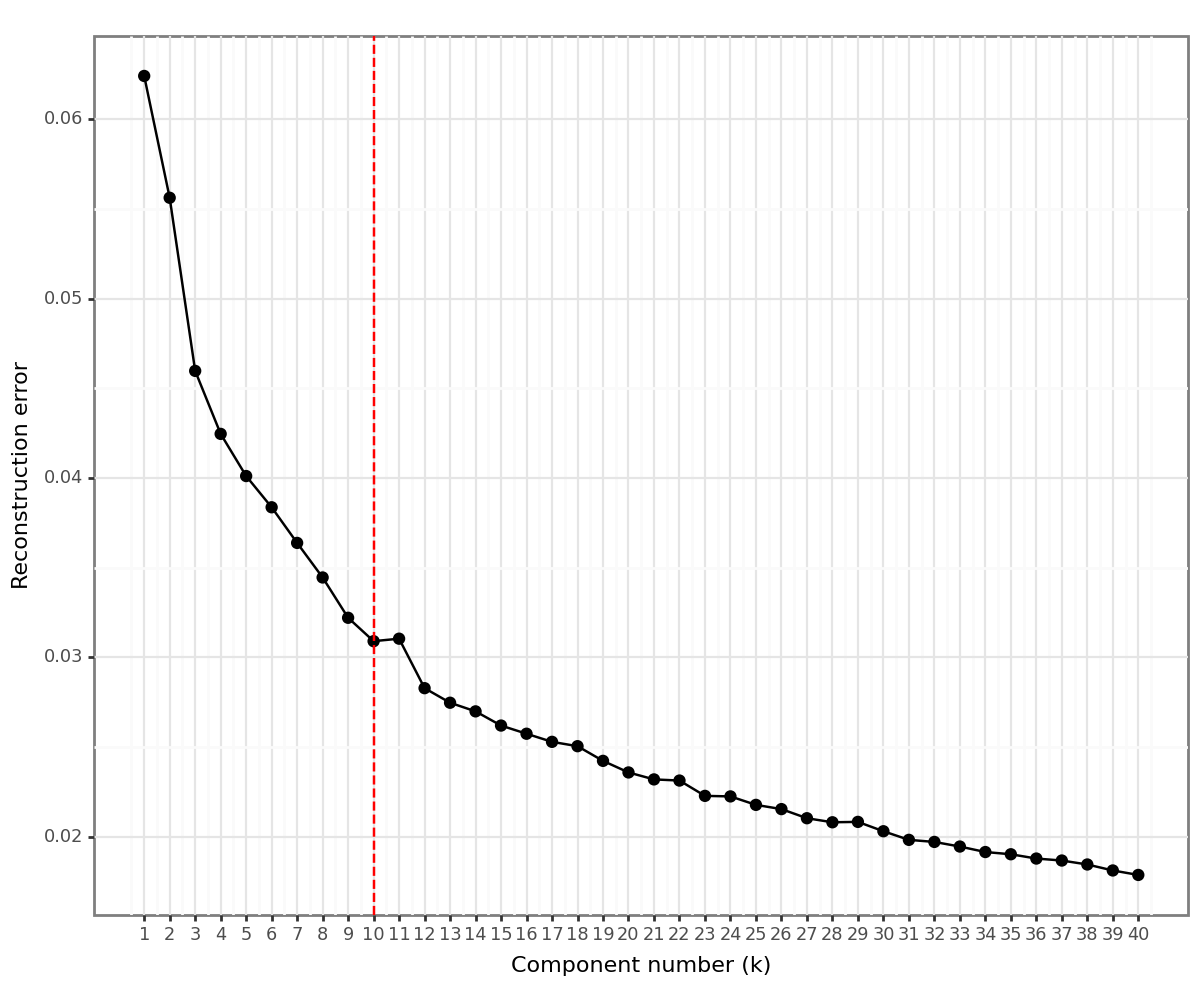

<Figure Size: (600 x 500)>

In [21]:
p

In [22]:
# annotate W and H
W = pd.DataFrame(W, index=liana_res.index)
W.columns = ['Factor' + str(i + 1) for i in range(W.shape[1])]
H = pd.DataFrame(H, index=liana_res.columns)
H.columns = ['Factor' + str(i + 1) for i in range(H.shape[1])]

In [23]:
W.to_csv(os.path.join('results', "factor_scores.csv"))
H.to_csv(os.path.join('results', "factor_loadings.csv"))

Pathway Enrichment on the LRs

In [24]:
estimate, pvals = dc.run_mlm(H.T, lr_progeny, source="source", target="interaction", use_raw=False)

In [25]:
# pivot columns to long
estimate = (estimate.
            melt(ignore_index=False, value_name='estimate', var_name='pathway').
            reset_index().
            rename(columns={'index':'factor'})
            )
# pivot columns to long
pvals = (pvals.
            melt(ignore_index=False, value_name='pval', var_name='pathway').
            reset_index().
            rename(columns={'index':'factor'})
        )

In [26]:
vmax = 4

dc_res = estimate.merge(pvals, on=['factor', 'pathway']).copy()
dc_res.loc[dc_res['estimate'] >= vmax, 'estimate'] = vmax

# assign * if adj_pval < 0.05
dc_res['adj_pval'] = dc.p_adjust_fdr(dc_res['pval'])
dc_res['significant'] = dc_res['adj_pval'].apply(lambda x: '*' if x < 0.05 else '')
sig_paths = dc_res[dc_res['adj_pval'] <= 0.05]['pathway'].unique()


In [27]:
# factors with significant pathways
sig_factors = dc_res[dc_res['adj_pval'] <= 0.05]['factor'].unique()
sig_factors = sorted(sig_factors, key=alphanumeric_sort_key)

In [28]:
dc_res = dc_res[dc_res['pathway'].isin(sig_paths)]

In [29]:
fct_order = sorted(dc_res['factor'].unique(), key=alphanumeric_sort_key)
dc_res['factor'] = dc_res['factor'].astype('category')
dc_res['factor'] = dc_res['factor'].cat.reorder_categories(fct_order)

## Extended Figure 8k

In [30]:
## p9 tile plot
plot = (p9.ggplot(dc_res) +
 p9.aes(x='pathway', y='factor') +
 p9.geom_tile(p9.aes(fill='estimate')) +
 # geom text significant
 p9.geom_text(p9.aes(label='significant'), size=14, color='white', fontstyle='oblique') +
 p9.theme_bw(base_size=20) +
 p9.theme(figure_size=(4.5, 4.5), axis_text_x=p9.element_text(angle=90)) +
 p9.scale_fill_gradient2(low='#1f77b4', high='#c20019', limits=(-vmax, vmax)) +
 p9.labs(x='Pathway', y='', fill='')
)

In [31]:
plot.draw()
plot.save(os.path.join('figures', 'pathways.pdf'))

Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 4.5 x 4.5 in image.
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/pathways.pdf
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


## Extended Figure 8l

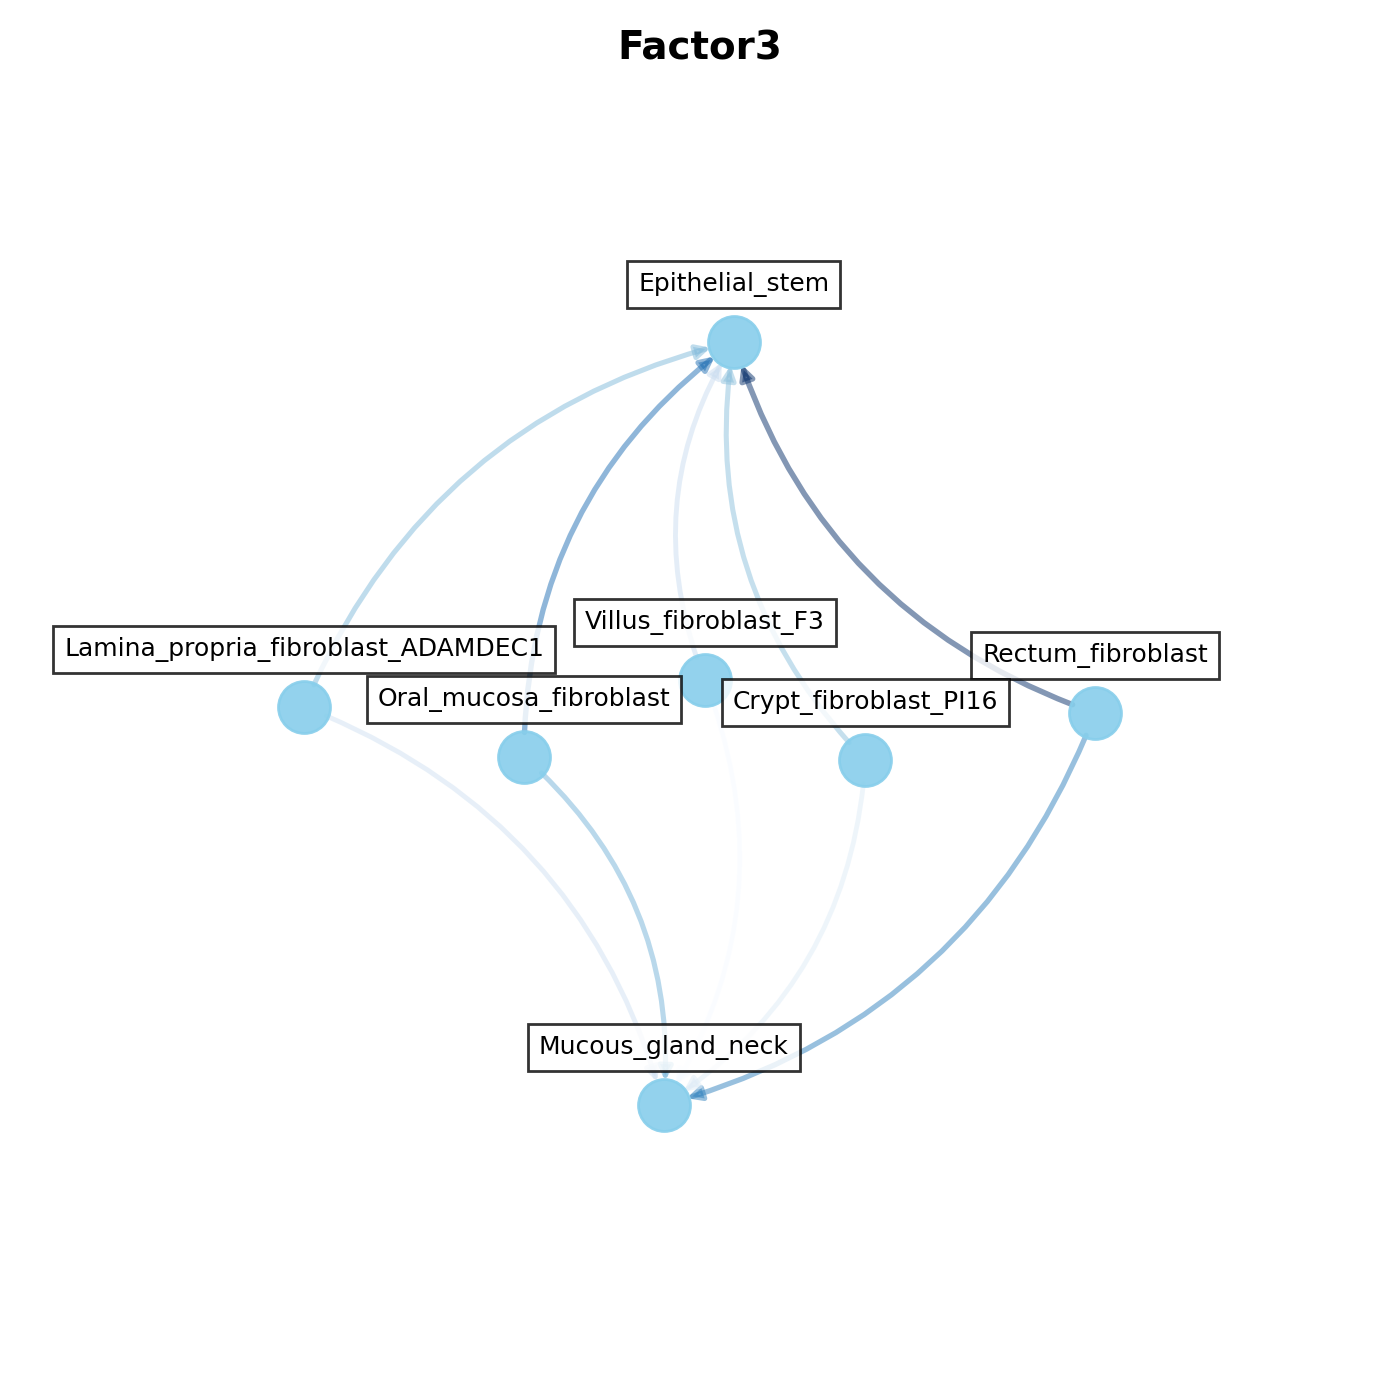

In [34]:
factor = 'Factor3'
cell_pairs = get_cellpairs(W, factor)
plot_network(cell_pairs,
             score_key=factor,
             top_n=10,
             network_layout='spring',
             k=1, 
             seed=4,
             filename=os.path.join("figures", "nmf", f"{factor}_network.pdf")
             )

plt.show()

## Extended Figure 8m
NRG1/AREG/EREG signalling axis

In [43]:
dea_df = pd.read_csv(os.path.join("results", "dea_results.csv"), index_col=0)
dea_df.rename(columns={'cell_type': groupby}, inplace=True)

DF to LR

In [44]:
sdata.obs[groupby] = sdata.obs['level_3_annot']

In [45]:
lr_res = li.multi.df_to_lr(sdata,
                           dea_df=dea_df,
                           expr_prop=0.05, # calculated for adata as passed - used to filter interactions
                           groupby=groupby,
                           stat_keys=['log2FoldChange', 'pvalue', 'padj'],
                           use_raw=False,
                           complex_col='expr',
                           verbose=True,
                           return_all_lrs=False,
                           )



Using resource `consensus`.
Using `.X`!
236 features of mat are empty, they will be removed.
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/liana/method/_pipe_utils/_pre.py:148: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
The following cell identities were excluded: EC_cycling, Enteric_neural_crest_cycling, Eosinophil/basophil, Megakaryocyte/platelet, Mesothelium
0.12 of entities in the resource are missing from the data.


In [47]:
lr_res.sort_values('interaction_log2FoldChange', ascending=False, key=abs).head()

,ligand,receptor,ligand_complex,receptor_complex,source,ligand_expr,ligand_props,ligand_log2FoldChange,ligand_pvalue,ligand_padj,...,receptor_props,receptor_log2FoldChange,receptor_pvalue,receptor_padj,interaction_expr,interaction_props,interaction_log2FoldChange,interaction_pvalue,interaction_padj,interaction
308970,PLA2G2A,ITGA5,PLA2G2A,ITGA5,Mucous_gland_neck,0.409114,0.156398,8.245337,5.346035e-17,1.292137e-13,...,0.417219,0.793216,0.002042,0.009758,0.463766,0.286808,4.519277,0.001021,0.004879,PLA2G2A^ITGA5
309086,PLA2G2A,ITGAV,PLA2G2A,ITGAV,Mucous_gland_neck,0.409114,0.156398,8.245337,5.346035e-17,1.292137e-13,...,0.061651,0.562147,0.099004,0.333354,0.216474,0.109025,4.403742,0.049502,0.166677,PLA2G2A^ITGAV
306538,PLA2G2A,ITGAV,PLA2G2A,ITGAV,Mucous_gland_neck,0.409114,0.156398,8.245337,5.346035e-17,1.292137e-13,...,0.252203,0.258728,0.024410,0.227457,0.352524,0.204300,4.252032,0.012205,0.113728,PLA2G2A^ITGAV
308414,PLA2G2A,ITGA4,PLA2G2A,ITGA4,Mucous_gland_neck,0.409114,0.156398,8.245337,5.346035e-17,1.292137e-13,...,0.282427,0.224587,0.121652,0.413758,0.405060,0.219412,4.234962,0.060826,0.206879,PLA2G2A^ITGA4
305554,PLA2G2A,ITGA4,PLA2G2A,ITGA4,Mucous_gland_neck,0.409114,0.156398,8.245337,5.346035e-17,1.292137e-13,...,0.438776,0.187768,0.297265,0.645689,0.442620,0.297587,4.216553,0.148633,0.322845,PLA2G2A^ITGA4


/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 30 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


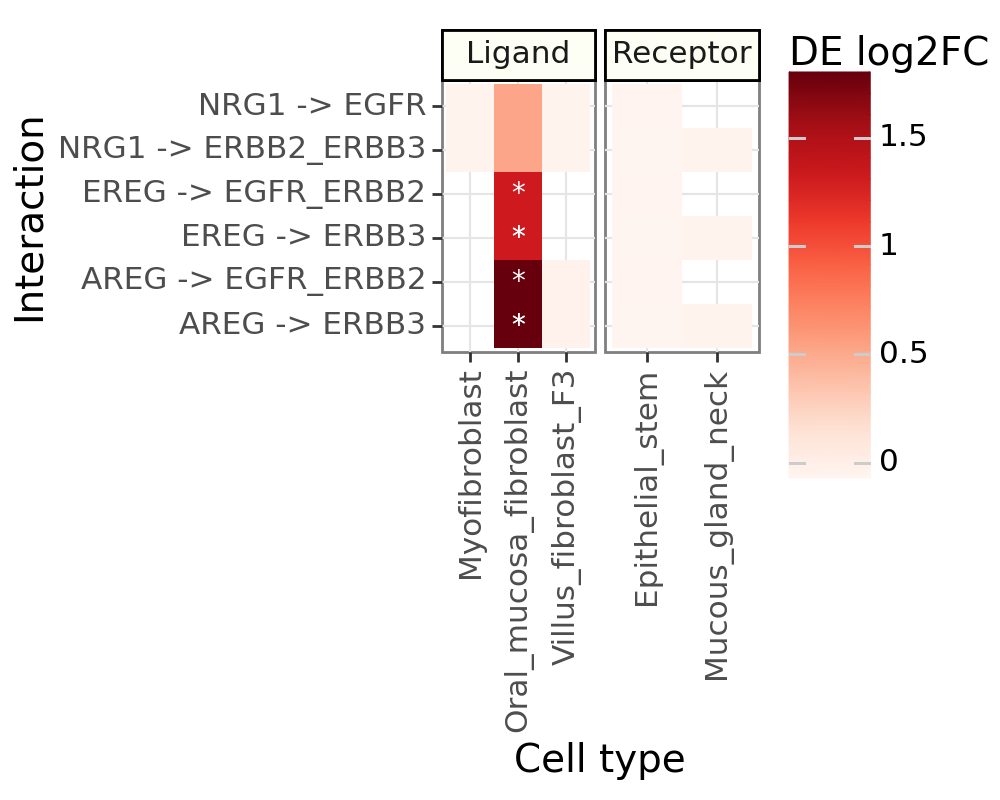

In [49]:
plot = (li.pl.tileplot(liana_res=lr_res,
                       fill = 'log2FoldChange',
                       label='padj',
                       source_labels=lr_res['source'][lr_res['source'].str.contains('fibro')].unique(),
                       target_labels=['Epithelial_stem', 'Mucous_gland_neck'],
                       ligand_complex=["NRG1", 'EREG', 'AREG'], 
                       receptor_complex=["ERBB3", "ERBB2_ERBB3", "EGFR_ERBB2", "EGFR"],
                       label_fun = lambda x: '*' if x < 0.05 else np.nan,
                       top_n=25,
                       orderby = 'interaction_log2FoldChange',
                       orderby_ascending = False,
                       orderby_absolute = False,
                       source_title='Ligand',
                       target_title='Receptor',
                       cmap='Reds',
                       figure_size=(5, 4),
                       ) +
        p9.labs(fill='\nDE log2FC\n')
)
plot.draw()

In [50]:
plot.save(os.path.join("figures", "nrg1_tileplot_logFC.pdf"))

/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/ggplot.py:587: PlotnineWarning: Saving 5 x 4 in image.
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/ggplot.py:588: PlotnineWarning: Filename: figures/nrg1_tileplot_logFC.pdf
/home/dbdimitrov/miniconda3/envs/pangi/lib/python3.8/site-packages/plotnine/layer.py:364: PlotnineWarning: geom_text : Removed 30 rows containing missing values.
Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt
